In [1]:
#| default_exp models.deepar

# DeepAR

The DeepAR methodology produces conditional probabilistic forecasts based on an Seq2Seq autoregressive neural network optimized on panel data using cross-learning.
$$\mathbb{P}(\mathbf{y}_{[t+1:t+H]}|\;\mathbf{y}_{[:t]},\; \mathbf{x}^{(h)}_{[:t]},\; \mathbf{x}^{(f)}_{[:t+H]},\; \mathbf{x}^{(s)})$$

where $\mathbf{x}^{(s)}$ are static exogenous inputs, $\mathbf{x}^{(h)}_{t}$ historic exogenous, $\mathbf{x}^{(f)}_{[:t+H]}$ are future exogenous available at the time of the prediction.

Our version of DeepAR first encodes the temporal variables with a RNN and then obtains its forecast distribution parameters using a recurrent decoder.
The predictions are obtained by transforming the hidden states $\mathbf{h}_{t}$ into recurrent predictive distribution parameters $\theta_{\tau}$.

\begin{align}
\mathbf{h}_{t} &= \textrm{EncoderRNN}([\mathbf{y}_{t},\mathbf{x}^{(h)}_{t},\mathbf{x}^{(s)}], \mathbf{h}_{t-1})\\
\mathbf{\theta}_{\tau+1}&=\textrm{DecoderRNN}([\mathbf{h}_{t}, \mathbf{x}^{(f)}_{\tau}], \mathbf{\theta}_{\tau}) \qquad \tau \in [t+1:t+h]\\
\hat{y}_{\tau} &\sim \;\mathrm{P}(y_{\tau}\;|\;\mathbf{\theta}_{\tau})\;
\end{align}

We deviate minimally from the original DeepAR implementation that in contrast uses a Markov Chain Monte Carlo sampler that is fed into the model inputs
recursively.

**References**<br>
- [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020). "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>
- [Alexander Alexandrov et. al (2020). "GluonTS: Probabilistic and Neural Time Series Modeling in Python". Journal of Machine Learning Research.](https://www.jmlr.org/papers/v21/19-820.html)<br>

![Figure 1. DeepAR model, during training the optimization signal comes from likelihood of observations, during inference a recurrent multi-step strategy is used to generate predictive distributions.](imgs_models/deepar.png)

In [2]:
#| hide
#TODO: Rethink the usage of Variable Selection Networks
#TODO: Rethink the usage of TFT embeddings.
#TODO: Add GRN, VSN into common to share across DeepAR/TFT.

In [3]:
#| hide
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [4]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn import LayerNorm

import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

from typing import Tuple, Optional

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows
from neuralforecast.common._modules import MLP

In [5]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [6]:
#| hide
import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

## 1. Auxiliary Functions

### 1.1 Gating Mechanisms

The Gated Residual Network (GRN) provides adaptive depth and network complexity capable of accommodating different size datasets. As residual connections allow for the network to skip the non-linear transformation of input $\mathbf{a}$ and context $\mathbf{c}$.

\begin{align}
\eta_{1} &= \mathrm{ELU}(\mathbf{W}_{1}\mathbf{a}+\mathbf{W}_{2}\mathbf{c}+\mathbf{b}_{1}) \\
\eta_{2} &= \mathbf{W}_{2}\eta_{1}+b_{2} \\
\mathrm{GRN}(\mathbf{a}, \mathbf{c}) &= \mathrm{LayerNorm}(a + \textrm{GLU}(\eta_{2}))
\end{align}

The Gated Linear Unit (GLU) provides the flexibility of supressing unnecesary parts of the GRN. Consider GRN's output $\gamma$ then GLU transformation is defined by:

$$\mathrm{GLU}(\gamma) = \sigma(\mathbf{W}_{4}\gamma +b_{4}) \odot (\mathbf{W}_{5}\gamma +b_{5})$$

In [7]:
#| exporti
class MaybeLayerNorm(nn.Module):
    def __init__(self, output_size, hidden_size, eps):
        super().__init__()
        if output_size and output_size == 1:
            self.ln = nn.Identity()
        else:
            self.ln = LayerNorm(output_size if output_size else hidden_size,
                                eps=eps)

    def forward(self, x):
        return self.ln(x)

class GLU(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.lin = nn.Linear(hidden_size, output_size * 2)

    def forward(self, x: Tensor) -> Tensor:
        x = self.lin(x)
        x = F.glu(x)
        return x

class GRN(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size, 
                 output_size=None,
                 context_hidden_size=None,
                 dropout=0):
        super().__init__()
        
        self.layer_norm = MaybeLayerNorm(output_size, hidden_size, eps=1e-3)
        self.lin_a = nn.Linear(input_size, hidden_size)
        if context_hidden_size is not None:
            self.lin_c = nn.Linear(context_hidden_size, hidden_size, bias=False)
        self.lin_i = nn.Linear(hidden_size, hidden_size)
        self.glu = GLU(hidden_size, output_size if output_size else hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(input_size, output_size) if output_size else None

    def forward(self, a: Tensor, c: Optional[Tensor] = None):
        x = self.lin_a(a)
        if c is not None:
            x = x + self.lin_c(c).unsqueeze(1)
        x = F.elu(x)
        x = self.lin_i(x)
        x = self.dropout(x)
        x = self.glu(x)
        y = a if not self.out_proj else self.out_proj(a)
        x = x + y
        x = self.layer_norm(x)
        return x

### 1.2 Variable Selection Networks

DeepAR and TFT include automated variable selection capabilities, through its variable selection network (VSN) components. The VSN takes the original input $\{\mathbf{x}^{(s)}, \mathbf{x}^{(h)}_{[:t]}, \mathbf{x}^{(f)}_{[:t]}\}$ and transforms it through embeddings or linear transformations into a high dimensional space
$\{\mathbf{E}^{(s)}, \mathbf{E}^{(h)}_{[:t]}, \mathbf{E}^{(f)}_{[:t+H]}\}$. 

For the observed historic data, the embedding matrix $\mathbf{E}^{(h)}_{t}$ at time $t$ is a concatenation of $j$ variable $e^{(h)}_{t,j}$ embeddings:
\begin{align}
\mathbf{E}^{(h)}_{t} &= [e^{(h)}_{t,1},\dots,e^{(h)}_{t,j},\dots,e^{(h)}_{t,n_{h}}] \\
\mathbf{\tilde{e}}^{(h)}_{t,j} &= \mathrm{GRN}(e^{(h)}_{t,j})
\end{align}

The variable selection weights are given by:
$$s^{(h)}_{t}=\mathrm{SoftMax}(\mathrm{GRN}(\mathbf{E}^{(h)}_{t},\mathbf{E}^{(s)}))$$

The VSN processed features are then:
$$\tilde{\mathbf{E}}^{(h)}_{t}= \sum_{j} s^{(h)}_{j} \tilde{e}^{(h)}_{t,j}$$

In [8]:
#| exporti
class TFTEmbedding(nn.Module):
    def __init__(self, hidden_size, stat_input_size, futr_input_size, hist_input_size, tgt_size):
        super().__init__()
        # There are 4 types of input:
        # 1. Static continuous
        # 2. Temporal known a priori continuous
        # 3. Temporal observed continuous
        # 4. Temporal observed targets (time series obseved so far)

        self.hidden_size = hidden_size

        self.stat_input_size = stat_input_size
        self.futr_input_size = futr_input_size
        self.hist_input_size = hist_input_size
        self.tgt_size        = tgt_size

        # Instantiate Continuous Embeddings if size is not None
        for attr, size in [('stat_exog_embedding', stat_input_size), 
                           ('futr_exog_embedding', futr_input_size),
                           ('hist_exog_embedding', hist_input_size),
                           ('tgt_embedding', tgt_size)]:
            if size:
                vectors = nn.Parameter(torch.Tensor(size, hidden_size))
                bias = nn.Parameter(torch.zeros(size, hidden_size))
                torch.nn.init.xavier_normal_(vectors)
                setattr(self, attr+'_vectors', vectors)
                setattr(self, attr+'_bias', bias)
            else:
                setattr(self, attr+'_vectors', None)
                setattr(self, attr+'_bias', None)

    def _apply_embedding(self,
                         cont: Optional[Tensor],
                         cont_emb: Tensor,
                         cont_bias: Tensor,
                         ):

        if (cont is not None):
            #the line below is equivalent to following einsums
            #e_cont = torch.einsum('btf,fh->bthf', cont, cont_emb)
            #e_cont = torch.einsum('bf,fh->bhf', cont, cont_emb)          
            e_cont = torch.mul(cont.unsqueeze(-1), cont_emb)
            e_cont = e_cont + cont_bias
            return e_cont
        
        return None

    def forward(self, target_inp, 
                stat_exog=None, futr_exog=None, hist_exog=None):
        # temporal/static categorical/continuous known/observed input 
        # tries to get input, if fails returns None

        # Static inputs are expected to be equal for all timesteps
        # For memory efficiency there is no assert statement
        stat_exog = stat_exog[:,:] if stat_exog is not None else None

        s_inp = self._apply_embedding(cont=stat_exog,
                                      cont_emb=self.stat_exog_embedding_vectors,
                                      cont_bias=self.stat_exog_embedding_bias)
        k_inp = self._apply_embedding(cont=futr_exog,
                                      cont_emb=self.futr_exog_embedding_vectors,
                                      cont_bias=self.futr_exog_embedding_bias)
        o_inp = self._apply_embedding(cont=hist_exog,
                                      cont_emb=self.hist_exog_embedding_vectors,
                                      cont_bias=self.hist_exog_embedding_bias)

        # Temporal observed targets
        # t_observed_tgt = torch.einsum('btf,fh->btfh', 
        #                               target_inp, self.tgt_embedding_vectors)        
        target_inp = torch.matmul(target_inp.unsqueeze(3).unsqueeze(4),
                          self.tgt_embedding_vectors.unsqueeze(1)).squeeze(3)
        target_inp = target_inp + self.tgt_embedding_bias

        return s_inp, k_inp, o_inp, target_inp

class VariableSelectionNetwork(nn.Module):
    def __init__(self, hidden_size, num_inputs, dropout):
        super().__init__()
        self.joint_grn = GRN(input_size=hidden_size*num_inputs, 
                             hidden_size=hidden_size, 
                             output_size=num_inputs, 
                             context_hidden_size=hidden_size)
        self.var_grns = nn.ModuleList(
                        [GRN(input_size=hidden_size, 
                             hidden_size=hidden_size, dropout=dropout)
                         for _ in range(num_inputs)])

    def forward(self, x: Tensor, context: Optional[Tensor] = None):
        Xi = x.reshape(*x.shape[:-2], -1)
        grn_outputs = self.joint_grn(Xi, c=context)
        sparse_weights = F.softmax(grn_outputs, dim=-1)
        transformed_embed_list = [m(x[...,i,:])
                                     for i, m in enumerate(self.var_grns)]
        transformed_embed = torch.stack(transformed_embed_list, dim=-1)
        #the line below performs batched matrix vector multiplication
        #for temporal features it's bthf,btf->bth
        #for static features it's bhf,bf->bh
        variable_ctx = torch.matmul(transformed_embed, 
                                    sparse_weights.unsqueeze(-1)).squeeze(-1)

        return variable_ctx, sparse_weights

### 1.3 Static Covariate Encoder

The static embedding $\mathbf{E}^{(s)}$ is transformed by the StaticCovariateEncoder into contexts $c_{s}, c_{e}, c_{h}, c_{c}$. Where $c_{s}$ are temporal variable selection contexts, $c_{e}$ are TemporalFusionDecoder enriching contexts, and $c_{h}, c_{c}$ are LSTM's hidden/contexts for the TemporalCovariateEncoder.

\begin{align}
c_{s}, c_{e}, (c_{h}, c_{c}) & = \textrm{GRN}(\textrm{VSN}(\mathbf{E}^{(s)}))
\end{align}

In [9]:
#| exporti
class StaticCovariateEncoder(nn.Module):
    def __init__(self, hidden_size, num_static_vars, dropout):
        super().__init__()
        self.vsn = VariableSelectionNetwork(hidden_size=hidden_size,
                                            num_inputs=num_static_vars,
                                            dropout=dropout)
        self.context_grns = nn.ModuleList(
                              [GRN(input_size=hidden_size,
                                   hidden_size=hidden_size,
                                   dropout=dropout) for _ in range(4)])

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
        variable_ctx, sparse_weights = self.vsn(x)

        # Context vectors:
        # variable selection context
        # enrichment context
        # state_c context
        # state_h context
        cs, ce, ch, cc = tuple(m(variable_ctx) for m in self.context_grns)

        return cs, ce, ch, cc

### 1.4 Temporal Covariate Encoder

TemporalCovariateEncoder encodes the embeddings $\mathbf{E}^{(h)}, \mathbf{E}^{(f)}$ and contexts  $(c_{h}, c_{c})$ with an LSTM.

\begin{align}
\tilde{\mathbf{E}}^{(h)}_{[:t]} & = \textrm{VSN}(\mathbf{E}^{(h)}_{[:t]}, c_{s}) \\
\tilde{\mathbf{E}}^{(h)}_{[:t]} &= \mathrm{LSTM}(\tilde{\mathbf{E}}^{(h)}_{[:t]}, (c_{h}, c_{c})) \\
h_{[:t]} &= \mathrm{Gate}(\mathrm{LayerNorm}(\tilde{\mathbf{E}}^{(h)}_{[:t]}))
\end{align}

An analogous process is repeated for the future data, with the main difference that $\mathbf{E}^{(f)}$ contains the future available information.

\begin{align}
\tilde{\mathbf{E}}^{(f)}_{[t+1:t+h]} & = \textrm{VSN}(\mathbf{E}^{(h)}_{t+1:t+H}, \mathbf{E}^{(f)}_{t+1:t+H}, c_{s}) \\
\tilde{\mathbf{E}}^{(f)}_{[t+1:t+h]} &= \mathrm{LSTM}(\tilde{\mathbf{E}}^{(h)}_{[t+1:t+h]}, (c_{h}, c_{c})) \\
h_{[t+1:t+H]} &= \mathrm{Gate}(\mathrm{LayerNorm}(\tilde{\mathbf{E}}^{(f)}_{[t+1:t+h]}))
\end{align}

In [10]:
#| exporti
class TemporalCovariateEncoder(nn.Module):
    def __init__(self, hidden_size, 
                 num_historic_vars, num_future_vars, dropout):
        super(TemporalCovariateEncoder, self).__init__()

        self.history_vsn = VariableSelectionNetwork(
                                       hidden_size=hidden_size,
                                       num_inputs=num_historic_vars,
                                       dropout=dropout)
        self.history_encoder = nn.LSTM(input_size=hidden_size,
                                       hidden_size=hidden_size,
                                       batch_first=True)
        
        self.future_vsn = VariableSelectionNetwork(hidden_size=hidden_size,
                                                   num_inputs=num_future_vars,
                                                   dropout=dropout)
        self.future_encoder = nn.LSTM(input_size=hidden_size,
                                      hidden_size=hidden_size,
                                      batch_first=True)
        
        # Shared Gated-Skip Connection
        self.input_gate = GLU(hidden_size, hidden_size)
        self.input_gate_ln = LayerNorm(hidden_size, eps=1e-3)
    
    def forward(self, historical_inputs, future_inputs, cs, ch, cc):
        # [N,X_in,L] -> [N,hidden_size,L]
        historical_features, _ = self.history_vsn(historical_inputs, cs)
        history, state = self.history_encoder(historical_features, (ch, cc))

        future_features, _ = self.future_vsn(future_inputs, cs)
        future, _ = self.future_encoder(future_features, state)
        #torch.cuda.synchronize() # this call gives prf boost for unknown reasons

        input_embedding = torch.cat([historical_features, future_features], dim=1)
        temporal_features = torch.cat([history, future], dim=1)
        temporal_features = self.input_gate(temporal_features)
        temporal_features = temporal_features + input_embedding
        temporal_features = self.input_gate_ln(temporal_features)      
        return temporal_features

## 3. DeepAR

In [11]:
#| export
class DeepAR(BaseWindows):
    """ DeepAR

    DeepAR is a method for producing probabilistic forecasts. It uses two recurrent neural networks (RNN) 
    to encode temporal and static variables and generate forecast distribution parameters.
    
    Our version of DeepAR deviates slightly from the original GluonTS approach, which incorporates a 
    Markov Chain sampler in the optimization, while we employ a full Seq2Seq approach.

    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `decoder_layers`: int=2, number of layers for the MLP decoder.<br>    
    `stat_exog_list`: str list, static continuous columns.<br>
    `hist_exog_list`: str list, historic continuous columns.<br>
    `futr_exog_list`: str list, future continuous columns.<br>
    `hidden_size`: int, units of embeddings and encoders.<br>
    `dropout`: float (0, 1), dropout of inputs VSNs.<br>
    `shared_weights`: bool, If True, all blocks within each stack will share parameters. <br>
    `activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int, number of different series in each batch.<br>
    `windows_batch_size`: int=None, windows sampled from rolled data, default uses all.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int, random seed initialization for replicability.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References**<br>
    - [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020). "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>
    - [Alexander Alexandrov et. al (2020). "GluonTS: Probabilistic and Neural Time Series Modeling in Python". Journal of Machine Learning Research.](https://www.jmlr.org/papers/v21/19-820.html)<br>
    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    
    def __init__(self,
                 h,
                 input_size,
                 tgt_size: int = 1,
                 decoder_layers: int=2,
                 stat_exog_list = None,
                 hist_exog_list = None,
                 futr_exog_list = None,
                 hidden_size: int = 128,
                 dropout: float = 0.1,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size: int = 1024,
                 inference_windows_batch_size: int = 1024,
                 step_size: int = 1,
                 scaler_type: str = 'robust',
                 num_workers_loader = 0,
                 drop_last_loader = False,
                 random_seed: int = 1,
                 **trainer_kwargs
                 ):

        # Inherit BaseWindows class
        super(DeepAR, self).__init__(h=h,
                                  input_size=input_size,
                                  loss=loss,
                                  valid_loss=valid_loss,
                                  max_steps=max_steps,
                                  learning_rate=learning_rate,
                                  num_lr_decays=num_lr_decays,
                                  early_stop_patience_steps=early_stop_patience_steps,
                                  val_check_steps=val_check_steps,
                                  batch_size=batch_size,
                                  valid_batch_size=valid_batch_size,
                                  windows_batch_size=windows_batch_size,
                                  inference_windows_batch_size=inference_windows_batch_size,
                                  step_size=step_size,
                                  scaler_type=scaler_type,
                                  num_workers_loader=num_workers_loader,
                                  drop_last_loader=drop_last_loader,
                                  random_seed=random_seed,
                                  **trainer_kwargs)
        self.example_length = input_size + h
        self.decoder_layers = decoder_layers

        # Parse lists hyperparameters
        self.stat_exog_list = [] if stat_exog_list is None else stat_exog_list
        self.hist_exog_list = [] if hist_exog_list is None else hist_exog_list
        self.futr_exog_list = [] if futr_exog_list is None else futr_exog_list

        stat_input_size = len(self.stat_exog_list)
        futr_input_size = max(len(self.futr_exog_list), 1)
        hist_input_size = len(self.hist_exog_list)
        num_historic_vars = futr_input_size + hist_input_size + tgt_size

        #------------------------------- Encoders -----------------------------#
        self.embedding = TFTEmbedding(hidden_size=hidden_size,
                                      stat_input_size=stat_input_size,
                                      futr_input_size=futr_input_size,
                                      hist_input_size=hist_input_size,
                                      tgt_size=tgt_size)
        
        self.static_encoder = StaticCovariateEncoder(
                                      hidden_size=hidden_size,
                                      num_static_vars=stat_input_size,
                                      dropout=dropout)

        self.temporal_encoder = TemporalCovariateEncoder(
                                      hidden_size=hidden_size,
                                      num_historic_vars=num_historic_vars,
                                      num_future_vars=futr_input_size,
                                      dropout=dropout)

        #------------------------------ Decoders -----------------------------#
        # Decoder MLP
        #self.enrichment_grn = GRN(input_size=hidden_size,
        #                          hidden_size=hidden_size,
        #                          context_hidden_size=hidden_size, 
        #                          dropout=dropout)
        self.mlp_decoder = MLP(in_features=hidden_size,
                               out_features=self.loss.outputsize_multiplier,
                               hidden_size=hidden_size,
                               num_layers=self.decoder_layers,
                               activation='ReLU',
                               dropout=dropout)

    def forward(self, windows_batch):

        # Parsiw windows_batch
        y_insample = windows_batch['insample_y'][:,:, None] # <- [B,T,1]
        futr_exog  = windows_batch['futr_exog']
        hist_exog  = windows_batch['hist_exog']
        stat_exog  = windows_batch['stat_exog']

        if futr_exog is None:
            futr_exog = y_insample[:, [-1]]
            futr_exog = futr_exog.repeat(1, self.example_length, 1)

        s_inp, k_inp, o_inp, t_observed_tgt = self.embedding(target_inp=y_insample, 
                                                             hist_exog=hist_exog,
                                                             futr_exog=futr_exog,
                                                             stat_exog=stat_exog)

        #-------------------------------- Inputs ------------------------------#
        # Static context
        if s_inp is not None:
            #cs, ce, ch, cc = self.static_encoder(s_inp)
            cs, _, ch, cc = self.static_encoder(s_inp)
            ch, cc = ch.unsqueeze(0), cc.unsqueeze(0) # LSTM initial states
        else:
            # If None add zeros
            batch_size, example_length, target_size, hidden_size = t_observed_tgt.shape
            cs = torch.zeros(size=(batch_size, hidden_size)).to(y_insample.device)
            #ce = torch.zeros(size=(batch_size, hidden_size)).to(y_insample.device)
            ch = torch.zeros(size=(1, batch_size, hidden_size)).to(y_insample.device)
            cc = torch.zeros(size=(1, batch_size, hidden_size)).to(y_insample.device)

        # Historical inputs
        _historical_inputs = [k_inp[:,:self.input_size,:],
                              t_observed_tgt[:,:self.input_size,:]]
        if o_inp is not None:
            _historical_inputs.insert(0,o_inp[:,:self.input_size,:])
        historical_inputs = torch.cat(_historical_inputs, dim=-2)

        # Future inputs
        future_inputs = k_inp[:, self.input_size:]

        #---------------------------- Encode/Decode ---------------------------#
        # Embeddings + VSN + LSTM encoders
        temporal_features = self.temporal_encoder(historical_inputs=historical_inputs,
                                                  future_inputs=future_inputs,
                                                  cs=cs, ch=ch, cc=cc)

        # Rethink fusion with static variables, to enrich temporal features (see TFT)
        # In the abscence of temporal_fusion_decoder residual connections still needed
        temporal_features = temporal_features[:, self.input_size:, :]
        #temporal_features = self.enrichment_grn(temporal_features, c=ce)

        # Adapt output to loss
        output = self.mlp_decoder(temporal_features)
        output = self.loss.domain_map(output)

        return output

In [12]:
show_doc(DeepAR, title_level=3)

---

### DeepAR

>      DeepAR (h, input_size, tgt_size:int=1, decoder_layers:int=2,
>              stat_exog_list=None, hist_exog_list=None, futr_exog_list=None,
>              hidden_size:int=128, dropout:float=0.1, loss=MAE(),
>              valid_loss=None, max_steps:int=1000, learning_rate:float=0.001,
>              num_lr_decays:int=-1, early_stop_patience_steps:int=-1,
>              val_check_steps:int=100, batch_size:int=32,
>              valid_batch_size:Optional[int]=None, windows_batch_size:int=1024,
>              inference_windows_batch_size:int=1024, step_size:int=1,
>              scaler_type:str='robust', num_workers_loader=0,
>              drop_last_loader=False, random_seed:int=1, **trainer_kwargs)

DeepAR

DeepAR is a method for producing probabilistic forecasts. It uses two recurrent neural networks (RNN) 
to encode temporal and static variables and generate forecast distribution parameters.

Our version of DeepAR deviates slightly from the original GluonTS approach, which incorporates a 
Markov Chain sampler in the optimization, while we employ a full Seq2Seq approach.

**Parameters:**<br>
`h`: int, Forecast horizon. <br>
`input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
`decoder_layers`: int=2, number of layers for the MLP decoder.<br>    
`stat_exog_list`: str list, static continuous columns.<br>
`hist_exog_list`: str list, historic continuous columns.<br>
`futr_exog_list`: str list, future continuous columns.<br>
`hidden_size`: int, units of embeddings and encoders.<br>
`dropout`: float (0, 1), dropout of inputs VSNs.<br>
`shared_weights`: bool, If True, all blocks within each stack will share parameters. <br>
`activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int, number of different series in each batch.<br>
`windows_batch_size`: int=None, windows sampled from rolled data, default uses all.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int, random seed initialization for replicability.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

**References**<br>
- [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020). "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>
- [Alexander Alexandrov et. al (2020). "GluonTS: Probabilistic and Neural Time Series Modeling in Python". Journal of Machine Learning Research.](https://www.jmlr.org/papers/v21/19-820.html)<br>

In [13]:
show_doc(DeepAR.fit, name='DeepAR.fit', title_level=3)

---

### DeepAR.fit

>      DeepAR.fit (dataset, val_size=0, test_size=0, random_seed=None)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [14]:
show_doc(DeepAR.predict, name='DeepAR.predict', title_level=3)

---

### DeepAR.predict

>      DeepAR.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                      **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## Usage Example

In [15]:
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.91it/s]


[]

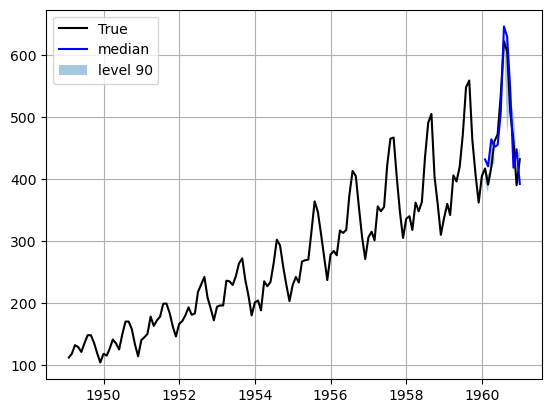

In [16]:
#| eval: false
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
#from neuralforecast.models import DeepAR
from neuralforecast.losses.pytorch import DistributionLoss, HuberMQLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

#AirPassengersPanel['y'] = AirPassengersPanel['y'] + 10
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

nf = NeuralForecast(
    models=[DeepAR(h=12, input_size=48,
                   hidden_size=10,
                   #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
                   #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                   loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                   #loss=HuberMQLoss(level=[80, 90]),
                   learning_rate=0.005,
                   stat_exog_list=['airline1'],
                   #futr_exog_list=['y_[lag12]'],
                   hist_exog_list=['trend'],
                   max_steps=500,
                   val_check_steps=10,
                   early_stop_patience_steps=10,
                   scaler_type='robust',
                   windows_batch_size=None,
                   enable_progress_bar=True),
    ],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
Y_hat_df = nf.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
#plt.plot(plot_df['ds'], plot_df['DeepAR'], c='purple', label='mean')
plt.plot(plot_df['ds'], plot_df['DeepAR-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['DeepAR-lo-90'][-12:].values, 
                 y2=plot_df['DeepAR-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()